In [1]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\djadh\Downloads\auto-research-report


In [2]:
from research_and_analyst.utils.model_loader import ModelLoader

In [3]:
ModelLoader()

{"timestamp": "2025-10-06T10:47:17.539567Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-06T10:47:17.541569Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-06T10:47:17.542568Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-06T10:47:17.544568Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-06T10:47:17.545567Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-06T10:47:17.549567Z", "level": "info", "event": "YAML config loaded"}


In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-10-06T10:47:21.691634Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-06T10:47:21.693634Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-06T10:47:21.694639Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-06T10:47:21.694639Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-06T10:47:21.695633Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-06T10:47:21.700633Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "deepseek-r1-distill-llama-70b", "timestamp": "2025-10-06T10:47:24.560792Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [72]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel ,Field

In [73]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [74]:
from IPython.display import Image ,display

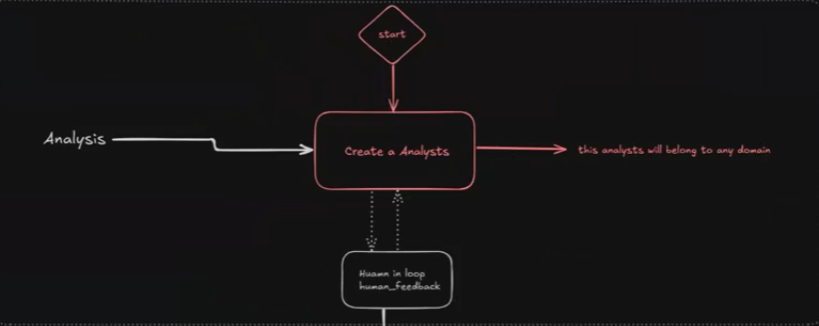

Pydantic Model

In [75]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [76]:
analyst = Analyst(
    name="Dmt xpress",
    role="genai Consultant",
    affiliation="DxU Research LAB",
    description="I am genai developer as well as mentor"
    )

In [77]:
analyst.name

'Dmt xpress'

In [78]:
analyst.role

'genai Consultant'

In [79]:
analyst.affiliation

'DxU Research LAB'

In [80]:
print(analyst.persona)

Name: Dmt xpress
Role: genai Consultant
Affiliation: DxU Research LAB
Description: I am genai developer as well as mentor



In [82]:
class Perspectives(BaseModel):
    analysts : List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [83]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts : List[Analyst]

In [84]:
class GenerateAnalystsState(TypedDict):
    topic:str 
    max_analysts : int 
    human_analyst_feedback : str
    analyst : List[Analyst]

In [85]:
GenerateAnalystsState(
    topic={"Sex among teenagers"},
    max_analysts=5,
    human_analyst_feedback="give the real info"
)

{'topic': {'Sex among teenagers'},
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [86]:
Analyst(
        name="Dr. Neha Jadhwani",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    )

Analyst(name='Dr. Neha Jadhwani', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.')

In [87]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [88]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n        \n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n        \nplease exaplain only on AI\n    \n3. Determine the most interesting themes based upon documents and / or feedback above.\n                    \n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


we use .get to fetch dictionary 

In [89]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [90]:
create_analyst(
    {'topic': 'comedy',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Carter', role='Cultural Comedy Analyst', affiliation='University of Cultural Studies', description='Dr. Emily Carter specializes in the cultural aspects of comedy, examining how humor varies across different societies and its role in shaping cultural identities.'),
  Analyst(name='Dr. Liam Reed', role='Psychology of Comedy Analyst', affiliation='Institute of Behavioral Science', description='Dr. Liam Reed focuses on the psychological mechanisms behind humor, exploring why people find certain things funny and the cognitive processes involved.')]}

In [91]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [92]:
def should_continue(state):
    """ Return the next node to execute
    """
    
    human_analyst_feedback = state.get("human_analyst_feedback" ,None)
    if human_analyst_feedback:
        return "create_analyst"

In [93]:
builder = StateGraph(GenerateAnalystsState)

In [94]:
builder.add_node("create_analyst",create_analyst)

In [95]:
builder.add_node("human_feedback",human_feedback)

In [96]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [97]:
memory = MemoryError()

In [104]:
graph = builder.compile(interrupt_before= ["human_feedback"])

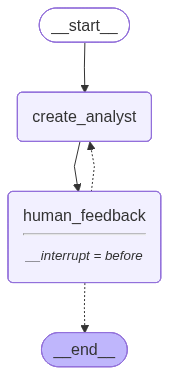

In [105]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [106]:
topic = "the benefits of adopting Autogen as an agent framework"

In [107]:
max_analysts = 2

In [102]:
thread =  {"configurable":{"thread_id":1}}

In [ ]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
